## Import

In [2]:
%autoreload
import statsmodels.api as sm
import numpy as np
import scipy
from scipy.signal import *
from scipy.interpolate import *
import platform

/home/yann/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(16,5)
plt.rcParams["axes.grid"] = True

In [4]:
import eventforecaster

## Utilities

In [5]:
def integral(x,y):
    return np.sum(np.diff(x)*(y[0:-1]+y[1:])/2)

In [6]:
def nan2zero(x):
    return np.where(np.isnan(x),0,x)

## Data

In [7]:
tdiff = np.array([31,32,38,34,23,36,31,32,30,29,32,31,31,30,29,36,29,31,35,32,33,34,34,31,33,38,31,37,31,30,29,28
])
tdiff_min_possible = 15
tdiff_max_possible = 50 

## Eventforecaster

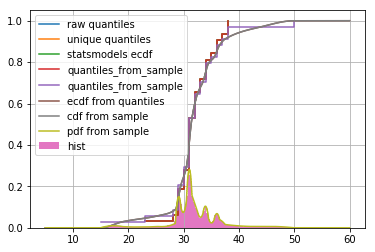

In [10]:
xu,ind,count = np.unique(np.sort(tdiff),return_index=True,return_counts=True)
q=(ind+count)/tdiff.size
values = np.linspace(tdiff_min_possible-10,tdiff_max_possible+10,10000)

pltkwargs={"drawstyle":"steps-post"}
plt.plot(np.sort(tdiff),np.arange(1,tdiff.size+1)/tdiff.size,label="raw quantiles",**pltkwargs)
plt.plot(xu,q,label="unique quantiles",**pltkwargs)
plt.plot(np.sort(tdiff),sm.distributions.ECDF(tdiff)(np.sort(tdiff)),label="statsmodels ecdf",**pltkwargs)
plt.plot(*eventforecaster.dist.CDF.quantiles_from_sample(tdiff),label="quantiles_from_sample",**pltkwargs)
plt.plot(*eventforecaster.dist.CDF.quantiles_from_sample(tdiff,tdiff_min_possible,tdiff_max_possible),label="quantiles_from_sample",**pltkwargs)

v,q=eventforecaster.dist.CDF.quantiles_from_sample(tdiff,tdiff_min_possible,tdiff_max_possible)
smooth_cdf=eventforecaster.dist.CDF.smooth_ecdf_from_quantiles(v,q)
plt.plot(values,smooth_cdf(values),label="ecdf from quantiles",**pltkwargs)

cdf = eventforecaster.dist.CDF.from_sample(tdiff,tdiff_min_possible,tdiff_max_possible)
plt.hist(cdf.sample(10000),label="hist",normed=True,bins=100)

plt.plot(values,eventforecaster.dist.CDF.from_sample(tdiff,tdiff_min_possible,tdiff_max_possible)(values),label="cdf from sample",**pltkwargs)
plt.plot(values,eventforecaster.dist.CDF.from_sample(tdiff,tdiff_min_possible,tdiff_max_possible).pdf(values),label="pdf from sample",**pltkwargs)


plt.legend()

0.99999987046


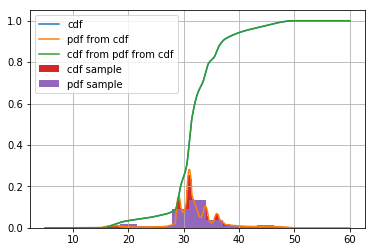

In [16]:
cdf = eventforecaster.dist.CDF.from_sample(tdiff,tdiff_min_possible,tdiff_max_possible,discretization=10000)

values = np.linspace(tdiff_min_possible-10,tdiff_max_possible+10,10000)

print(cdf.pdf.integral())

plt.plot(values,cdf(values),label="cdf")
plt.plot(values,cdf.pdf(values),label="pdf from cdf")
plt.plot(values,cdf.pdf.cdf(values),label="cdf from pdf from cdf")

plt.hist(cdf.sample(),bins=100,normed=True, label = "cdf sample")
plt.hist(cdf.pdf.sample(100),normed=True, label = "pdf sample")


plt.legend()

In [28]:
scipy.stats.truncnorm.cdf(4,a=tdiff_min_possible,b=tdiff_max_possible)

0.0

## Function

In [ ]:
def smooth_ecdf(x,xmin=None,xmax=None):
    if xmin is None:
        xmin = np.min(x)
    else:
        x = np.where(x<xmin, xmin, x)
    if xmax is None:
        xmax = np.max(x)
    else:
        x = np.where(x>xmax, xmax, x)
    x_ext = np.concatenate([[xmin],x,[xmax]])
    x_unique = np.unique(x)
    x_unique_ext = np.unique(x_ext)
    x_unique_mids = x_unique_ext[0:-1]+np.diff(x_unique_ext)/2
    cdf=sm.distributions.ECDF(x_ext)
    quantiles = cdf(x_unique_mids)
    interp_cdf = PchipInterpolator(
        np.concatenate([[xmin-abs(xmin)-1,xmin],x_unique_mids,[xmax,xmax+abs(xmax)+1]]),
        np.concatenate([[0,0],quantiles,[1,1]]),
        extrapolate = True
    )
    return interp_cdf

In [ ]:
cdf = smooth_ecdf(tdiff,tdiff_min_possible,tdiff_max_possible)
pdf = cdf.derivative()

In [ ]:
values = np.linspace(tdiff_min_possible-10,tdiff_max_possible+10,10000)
print("Integral under PDF: {}".format(integral(values,nan2zero(pdf(values)))))

In [ ]:
plt.plot(values,sm.distributions.ECDF(tdiff)(values),label="raw ecdf")
plt.plot(values,sm.distributions.ECDF(np.concatenate([[tdiff_min_possible],tdiff,[tdiff_max_possible]]))(values),label="extended ecdf")
plt.hist(np.where(tdiff<tdiff_min_possible,tdiff_min_possible,np.where(tdiff>tdiff_max_possible,tdiff_max_possible,tdiff)),align="left",bins=np.arange(tdiff_min_possible,tdiff_max_possible),normed=True,label="histogram")
plt.plot(values,cdf(values),label="cdf")
plt.plot(values,pdf(values),label="pdf")
plt.legend()

## Event propagation - Convolution

### New way

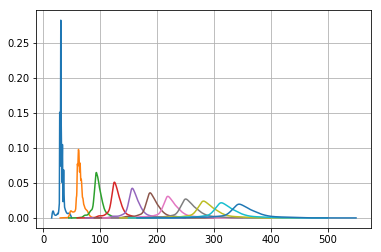

In [49]:
cdf = eventforecaster.dist.CDF.from_sample(tdiff,tdiff_min_possible,tdiff_max_possible)
pdf = cdf.pdf
pdfn = pdf
plt.plot(*pdfn.discrete)
for i in range(10):
    pdfn = pdfn.convolve(pdf)
    plt.plot(*pdfn.discrete)

### Event delay via CDF cutoff

In [ ]:
values = np.linspace(0,100,1000)
past_values = 15

base_cdf = smooth_ecdf(tdiff,tdiff_min_possible,tdiff_max_possible)
base_pdf = base_cdf.derivative()

cutoff_cdf = smooth_ecdf(tdiff,max(past_values,tdiff_min_possible),tdiff_max_possible)
cutoff_pdf = cutoff_cdf.derivative()

print("Integral under base PDF: {}".format(integral(values,nan2zero(base_pdf(values)))))
print("Integral under cutoff PDF: {}".format(integral(values,nan2zero(cutoff_pdf(values)))))

In [ ]:
plt.plot(values,base_cdf(values),label="base cdf")
plt.plot(values,base_pdf(values),label="base pdf")
plt.plot(values,cutoff_cdf(values),label="cdf cutoff")
plt.axvline(past_values,linestyle="--")
plt.plot(values,cutoff_pdf(values),label="pdf cutoff")
plt.legend()

In [ ]:
base_pdfv = base_pdf(values)
base_pdfs = sum(base_pdfv)
miv,mav = min(values), max(values)
pdfv_n = cutoff_pdf(values)
pdfvf = pdfv_n
v_n = values
plt.figure(figsize=(16,10))
plt.plot(v_n,pdfv_n)
for i in range(2,21):
    pdfv_n=scipy.signal.convolve(pdfv_n,base_pdfv,mode="full") / base_pdfs
    v_n = np.linspace(i*miv,i*mav,i*(values.size-1)+1)
    pdfvf = np.pad(pdfvf, (0,pdfv_n.size-pdfvf.size), "constant") + pdfv_n
    plt.plot(v_n,pdfv_n)
plt.plot(np.linspace(miv,i*mav,pdfvf.size),pdfvf,linewidth=3,label="full")
plt.xlim(past_values,560)
plt.ylim(None,0.5)
plt.legend()

## Random Walk

In [ ]:
random_walk=np.cumsum(np.random.random(1000)-0.5)

In [ ]:
plt.plot(random_walk)

In [ ]:
random_walk_fft=np.fft.rfft(random_walk)

In [ ]:
random_walk_fft_power=np.abs(random_walk_fft)**2

In [ ]:
plt.plot(random_walk_fft_power)
plt.yscale("log")

## Signal to Spectrum

In [ ]:
t,step = np.linspace(0,1000,500,retstep=True)
print("step: {}".format(step))

In [ ]:
signal=np.sin((2*np.pi)/100*t)

In [ ]:
plt.plot(t,signal)

In [ ]:
spectrum=np.fft.rfft(signal)

In [ ]:
power=abs(spectrum)**2
freq=np.fft.rfftfreq(signal.size,step)
print("dominant frequency: {}".format(freq[np.argmax(power)]))
print(1/(2*np.pi))

In [ ]:
plt.plot(freq,power)
plt.yscale("log")

## Fourrier to Signal

In [ ]:
spectrum=np.array([1]*1000)+0j

In [ ]:
freqs=np.fft.rfftfreq(spectrum)
plt.plot(freqs,spectrum)

In [ ]:
signal=np.fft.irfft(spectrum)

In [ ]:
plt.plot(signal)

### Event delay via convolution (fail)

In [ ]:
values=np.linspace(0,100,1000)
past_values = 35
base_pdf = nan2zero(pdf(values))

In [ ]:
delay_kernel = np.ones_like(values)
delay_kernel[values<max(past_values,tdiff_min_possible)] = 0
delay_kernel[values>max(past_values,tdiff_min_possible)+1] = 0
delay_kernel /= integral(values,delay_kernel) # normalize

if base_pdf[values<past_values].sum() > 0:
    delay_pdf = scipy.signal.convolve(base_pdf,delay_kernel,mode="full") / np.sum(delay_kernel)
    delay_values = np.linspace(values.min(),values.max(),2*values.size-1)
    delay_pdf[delay_values<past_values] = 0
    delay_pdf /= integral(delay_values,delay_pdf)
else:
    delay_values = values
    delay_pdf = base_pdf

plt.plot(values,base_pdf,label="base pdf")
plt.plot(values,delay_kernel,drawstyle="steps-post",label="delay kernel")
plt.axvline(past_values,linestyle="--")
plt.plot(delay_values,delay_pdf,label="delay pdf")
plt.xlim(10,60)
plt.legend()